In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [12]:
# Variables Initialization
data_file = '../data/HO-5minHLV.csv'
in_sample = [pd.to_datetime('10/02/2007'), pd.to_datetime('10/01/2017')]
out_sample = [pd.to_datetime('10/02/2017'), pd.to_datetime('04/21/2023')]
bars_back = 17000
slpg = 65
pv = 64000
Length = np.arange(10000, 10001, 100)  # Adjustable
StopPct = np.arange(0.015, 0.0155, 0.001)  # Adjustable
result_label = ['Profit', 'WorstDrawDown', 'StDev', '#trades']
result_in_sample = np.zeros((len(Length), len(StopPct), len(result_label)))
result_out_sample = np.zeros((len(Length), len(StopPct), len(result_label)))
E0 = 200000

In [13]:
# Load Data
df = pd.read_csv(data_file)
df['numTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['N'] = len(df['numTime'])
df['M'] = 5  # Assuming this relates to a specific attribute in the data, not shown in your example

In [14]:
df

,Date,Time,Open,High,Low,Close,Volume,numTime,N,M
0,01/03/1984,10:05,0.0000,0.0000,0.0000,0.0000,0,1984-01-03 10:05:00,611837,5
1,01/03/1984,10:10,1.2543,1.2568,1.2538,1.2568,0,1984-01-03 10:10:00,611837,5
2,01/03/1984,10:15,1.2568,1.2573,1.2563,1.2563,0,1984-01-03 10:15:00,611837,5
3,01/03/1984,10:20,1.2563,1.2568,1.2558,1.2568,0,1984-01-03 10:20:00,611837,5
4,01/03/1984,10:25,1.2563,1.2563,1.2538,1.2538,0,1984-01-03 10:25:00,611837,5
...,...,...,...,...,...,...,...,...,...,...
611832,03/23/2023,14:10,4.2828,4.2842,4.2791,4.2795,343,2023-03-23 14:10:00,611837,5
611833,03/23/2023,14:15,4.2800,4.2872,4.2791,4.2833,306,2023-03-23 14:15:00,611837,5
611834,03/23/2023,14:20,4.2834,4.2854,4.2749,4.2756,671,2023-03-23 14:20:00,611837,5
611835,03/23/2023,14:25,4.2759,4.2821,4.2723,4.2738,680,2023-03-23 14:25:00,611837,5


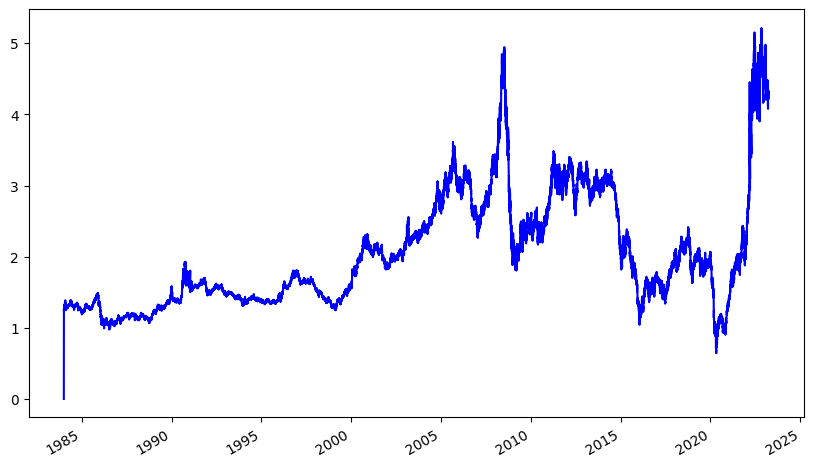

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df['numTime'], df['Close'], 'b')
plt.gcf().autofmt_xdate()
plt.show()

In [16]:
ind_in_sample = [max(np.sum(df['numTime'] < in_sample[0]), bars_back),
                 max(np.sum(df['numTime'] < in_sample[1] + pd.Timedelta(days=1)) - 1, bars_back)]
ind_out_sample = [max(np.sum(df['numTime'] < out_sample[0]), bars_back),
                  max(np.sum(df['numTime'] < out_sample[1] + pd.Timedelta(days=1)) - 1, bars_back)]

In [17]:
# Main Loop
for i, L in enumerate(Length):
  print(f'Calculating for Length = {L}')
  df['HH'] = df['High'].rolling(window=L, min_periods=1).max().shift(1)
  df['LL'] = df['Low'].rolling(window=L, min_periods=1).min().shift(1)

  for j, S in enumerate(StopPct):
    print(f'Calculating for StopPct = {S}')

    limitBuy = np.nan
    limitSell = np.nan
    stopOrder = np.nan

    position = 0
    E = np.zeros(len(df)) + E0
    DD = np.zeros(len(df))
    trades = np.zeros(len(df))
    Emax = E0

    for k in range(bars_back + 1, len(df)):
      traded = False
      delta = pv * (df['Close'].iloc[k] - df['Close'].iloc[k-1]) * position


      if position == 0:
        buy = df['High'].iloc[k] >= df['HH'].iloc[k]
        sell = df['Low'].iloc[k] <= df['LL'].iloc[k]
        if buy and sell:
          delta = -slpg + pv * (df['LL'].iloc[k] - df['HH'].iloc[k])
          trades[k] = 1
        else:
          if buy:
            delta = -slpg / 2 + pv *(df['Close'].iloc[k] - df['HH'].iloc[k])
            position = 1
            traded = True
            benchmarkLong = df['High'].iloc[k]
            trades[k] = 0.5
          if sell:
            delta = -slpg / 2 - pv * (df['Close'].iloc[k] - df['LL'].iloc[k])
            position = -1
            traded = True
            benchmarkShort = df['Low'].iloc[k]
            trades[k] = 0.5



      if position == 1 and not traded:
        sellShort = df['Low'].iloc[k] <= df['LL'].iloc[k]
        sell = df['Low'].iloc[k] <= (benchmarkLong * (1 - S))
        if sellShort and sell:
          if sellShort:
            delta = delta - slpg - 2 * pv * (df['Close'].iloc[k] - df['LL'].iloc[k])
            position = -1
            benchmarkShort = df['Low'].iloc[k]
            trades[k] = 1
        else:
          if sell:
            delta = delta - slpg / 2 - pv * (df['Close'].iloc[k] - (benchmarkLong * (1 - S)))
            position = 0
            trades[k] = 0.5
          if sellShort:
            delta = delta - slpg - 2 * pv * (df['Close'].iloc[k] - df['LL'].iloc[k])
            position = -1
            benchmarkShort = df['Low'].iloc[k]
            trades[k] = 1
        benchmarkLong = max(df['High'].iloc[k], benchmarkLong)

      if position == -1 and not traded:
        buyLong = df['High'].iloc[k] >= df['HH'].iloc[k]
        buy = df['High'].iloc[k] >= (benchmarkShort * (1 + S))
        if buyLong and buy:
          if buyLong:
            delta = delta - slpg + 2 * pv * (df['Close'].iloc[k] - df['HH'].iloc[k])
            position = 1
            benchmarkLong = df['High'].iloc[k]
            trades[k] = 1
        else:
          if buy:
            delta = delta - slpg / 2 + pv * (df['Close'].iloc[k] - (benchmarkShort * (1 + S)))
            position = 0
            trades[k] = 0.5
          if buyLong:
            delta = delta - slpg + 2 * pv * (df['Close'].iloc[k] - df['HH'].iloc[k])
            position = 1
            benchmarkLong = df['High'].iloc[k]
            trades[k] = 1
        benchmarkShort = min(df['Low'].iloc[k], benchmarkShort)

      E[k] = E[k - 1] + delta
      Emax = max(Emax, E[k])
      DD[k] = E[k] - Emax

    # Calculate statistics for in-sample and out-of-sample
    PnL = np.concatenate((np.zeros(bars_back), E[bars_back:] - E[bars_back-1:-1]))
    result_in_sample[i, j, :] = [E[ind_in_sample[1]] - E[ind_in_sample[0]],
                                  np.min(DD[ind_in_sample[0]:ind_in_sample[1]]),
                                  np.std(PnL[ind_in_sample[0]:ind_in_sample[1]]),
                                  np.sum(trades[ind_in_sample[0]:ind_in_sample[1]])]
    result_out_sample[i, j, :] = [E[ind_out_sample[1]] - E[ind_out_sample[0]],
                                  np.min(DD[ind_out_sample[0]:ind_out_sample[1]]),
                                  np.std(PnL[ind_out_sample[0]:ind_out_sample[1]]),
                                  np.sum(trades[ind_out_sample[0]:ind_out_sample[1]])]
    print(f': in/out: {result_in_sample[i, j, :]} / {result_out_sample[i, j, :]}')


Calculating for Length = 10000
Calculating for StopPct = 0.015
: in/out: [ 1.18773224e+05 -1.62865480e+04  9.31987757e+01  1.47000000e+02] / [ 90025.08     -19525.636       138.501715    137.      ]


In [18]:
ind = np.arange(ind_out_sample[0], ind_out_sample[1]+1)

/var/folders/4s/kkf94s7s013511xsv5c9mznc0000gn/T/ipykernel_82312/1220196425.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(df['numTime'].iloc[ind], (0.5 / trades[ind]) * df['HH'].iloc[ind], color='g', label='HH Stop')
/var/folders/4s/kkf94s7s013511xsv5c9mznc0000gn/T/ipykernel_82312/1220196425.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(df['numTime'].iloc[ind], (0.5 / trades[ind]) * df['LL'].iloc[ind], color='r', label='LL Stop')
/var/folders/4s/kkf94s7s013511xsv5c9mznc0000gn/T/ipykernel_82312/1220196425.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(df['numTime'].iloc[ind], (0.5 / trades[ind]) * df['HH'].iloc[ind] * (1 - StopPct[j]), color='blue', label='HH Stop with pct')
/var/folders/4s/kkf94s7s013511xsv5c9mznc0000gn/T/ipykernel_82312/1220196425.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(df['numTime'].iloc[ind], (0.5 / trades[ind]) * df['LL'].iloc[ind] * (1 + StopPct[j]), c

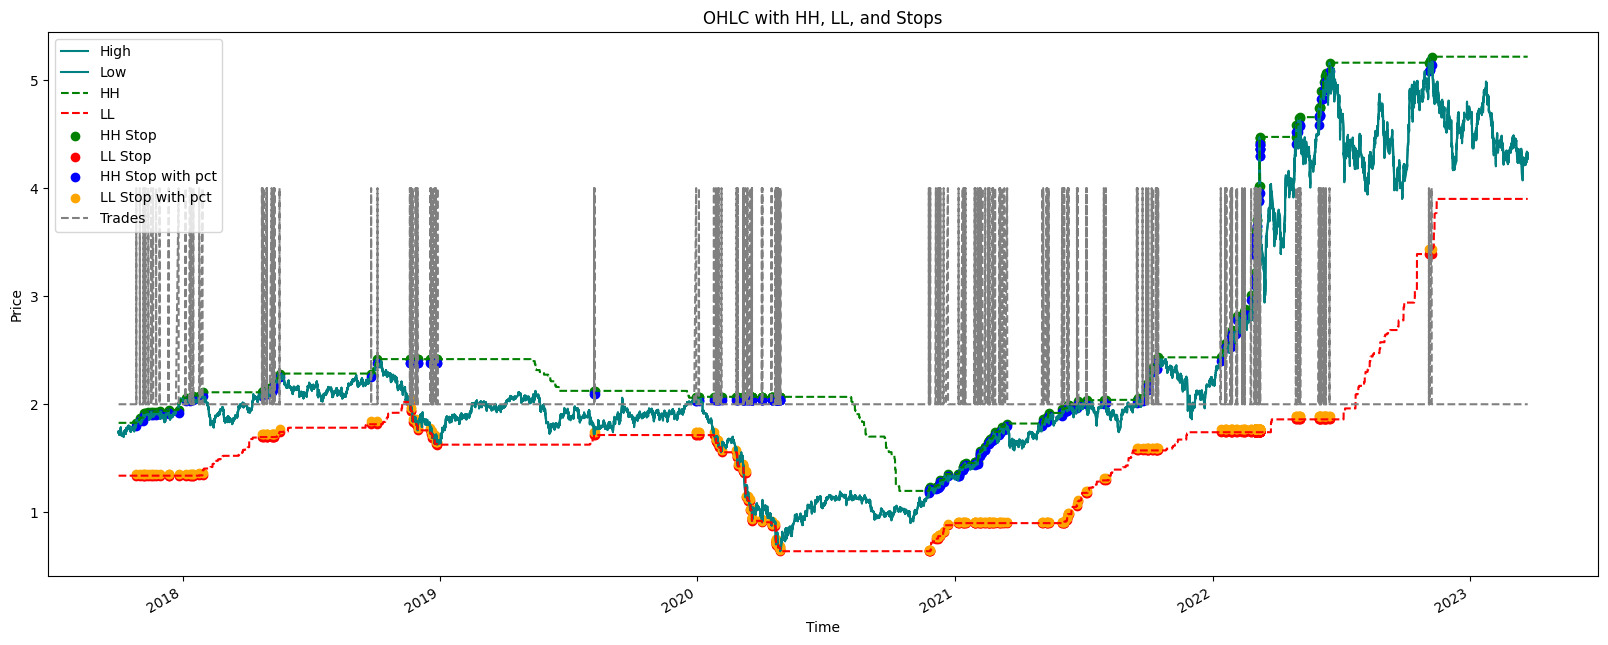

In [19]:
# Plotting OHLC with HH and LL
plt.figure(figsize=(20, 8))
plt.plot(df['numTime'].iloc[ind], df['High'].iloc[ind], 'teal', label='High')
plt.plot(df['numTime'].iloc[ind], df['Low'].iloc[ind], 'teal', label='Low')
plt.plot(df['numTime'].iloc[ind], df['HH'].iloc[ind], '--g', label='HH')
plt.plot(df['numTime'].iloc[ind], df['LL'].iloc[ind], '--r', label='LL')
plt.scatter(df['numTime'].iloc[ind], (0.5 / trades[ind]) * df['HH'].iloc[ind], color='g', label='HH Stop')
plt.scatter(df['numTime'].iloc[ind], (0.5 / trades[ind]) * df['LL'].iloc[ind], color='r', label='LL Stop')
plt.scatter(df['numTime'].iloc[ind], (0.5 / trades[ind]) * df['HH'].iloc[ind] * (1 - StopPct[j]), color='blue', label='HH Stop with pct')
plt.scatter(df['numTime'].iloc[ind], (0.5 / trades[ind]) * df['LL'].iloc[ind] * (1 + StopPct[j]), color='orange', label='LL Stop with pct')
plt.plot(df['numTime'].iloc[ind], trades[ind] * 4 + 2, linestyle='--', color='grey', label='Trades')
plt.gcf().autofmt_xdate()
plt.legend()
plt.title('OHLC with HH, LL, and Stops')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

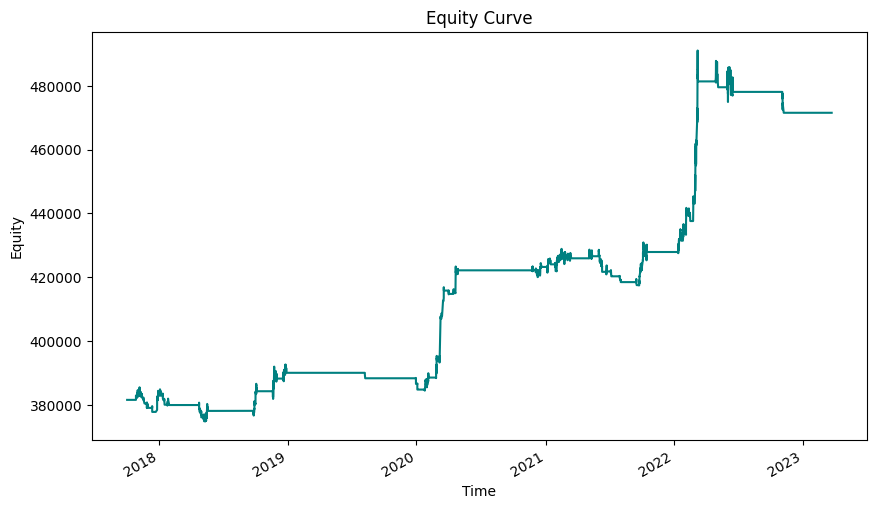

In [20]:
# Plotting Equity Curve
plt.figure(figsize=(10, 6))
plt.plot(df['numTime'].iloc[ind], E[ind], 'teal')
plt.gcf().autofmt_xdate()
plt.title('Equity Curve')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.show()

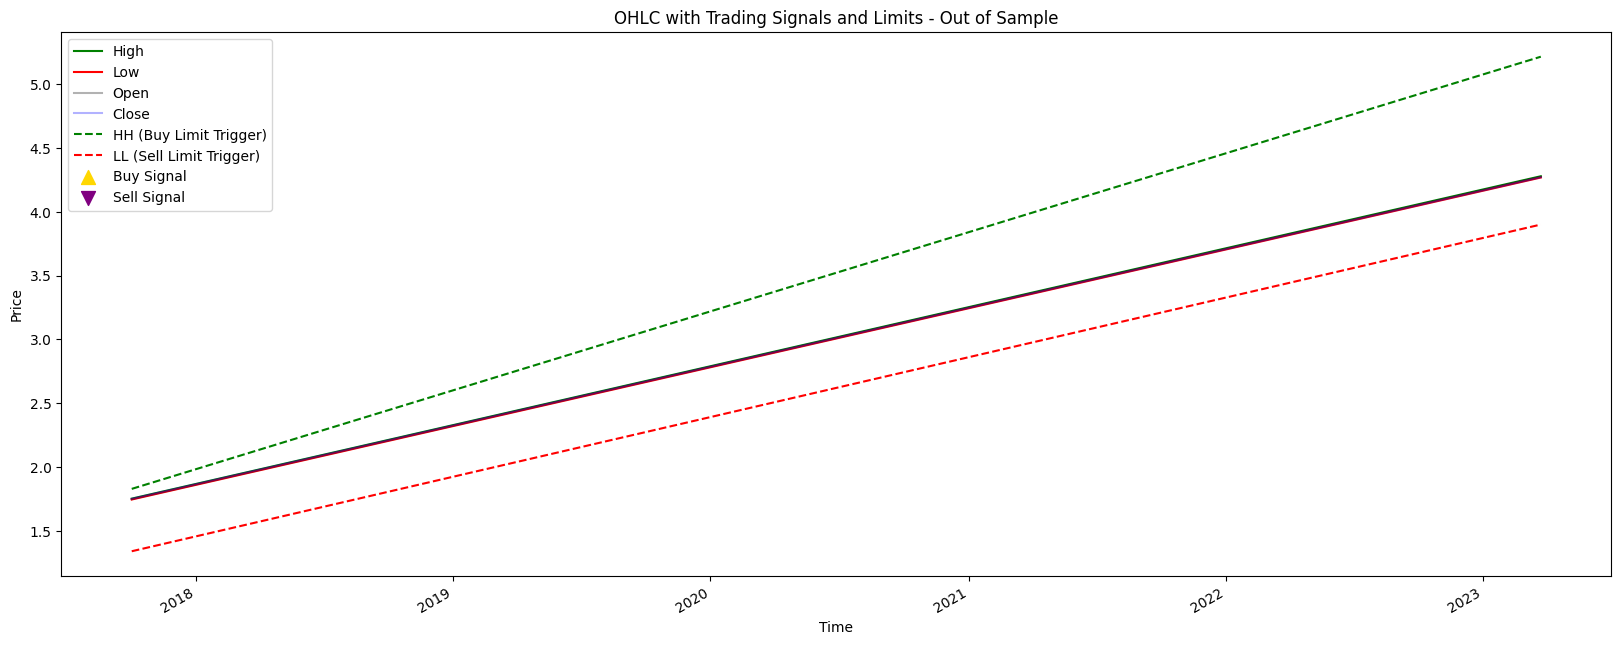

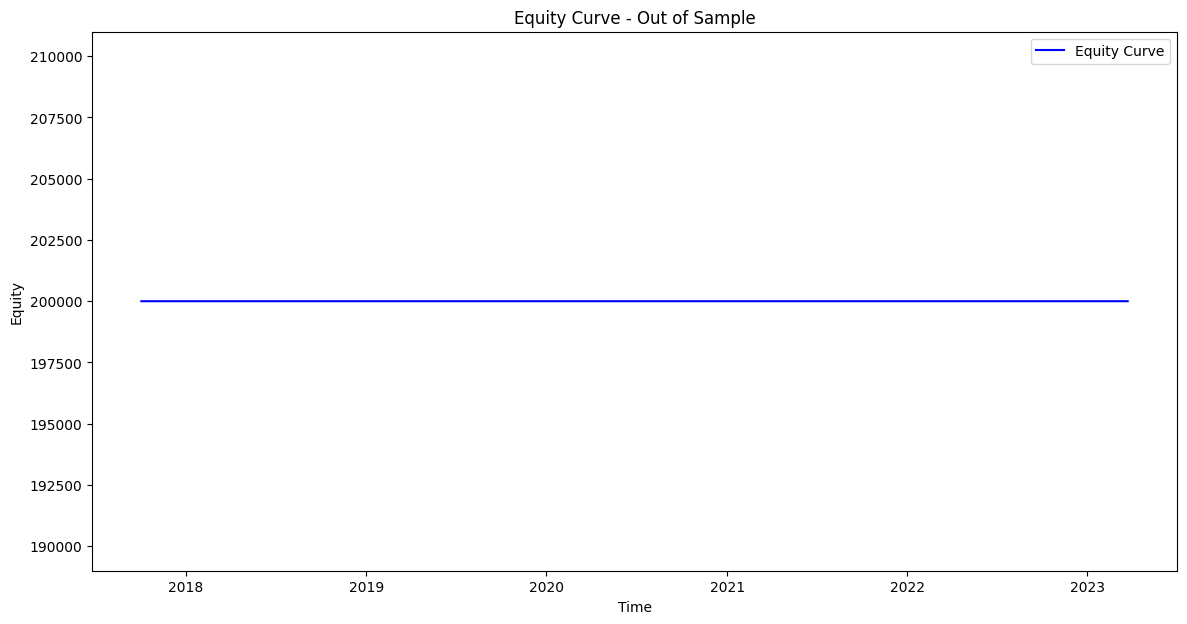

In [26]:
# Define necessary imports and read data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_file = '../data/HO-5minHLV.csv'
df = pd.read_csv(data_file)
df['numTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Define parameters and constants
bars_back = 17000
slpg = 0  # Assuming no slippage
pv = 64000
E0 = 200000
Length = np.arange(10000, 10001, 100)  # Adjustable
StopPct = np.arange(0.015, 0.0155, 0.001)  # Adjustable
tolerance = 0.005  # Tolerance factor for limit orders

# Calculate indices for in-sample and out-of-sample data
out_sample_start = pd.to_datetime('10/02/2017')
out_sample_end = pd.to_datetime('04/21/2023')
out_sample_mask = (df['numTime'] >= out_sample_start) & (df['numTime'] <= out_sample_end)

# Define and compute rolling maximum and minimum
df['HH'] = df['High'].rolling(window=10000, min_periods=10000).max().shift(2)
df['LL'] = df['Low'].rolling(window=10000, min_periods=10000).min().shift(2)
benchmarkLong = df['High'].iloc[0]
benchmarkShort = df['Low'].iloc[0]

# Initialize arrays to hold trading results and equity
trades = np.zeros(len(df))
E = np.zeros(len(df)) + E0
DD = np.zeros(len(df))
traded = False

# # Iterate through each time step in the data
for k in range(bars_back, len(df) - 1):
    # Entry logic

    buy = df['High'].iloc[k] >= df['HH'].iloc[k]
    sell = df['Low'].iloc[k] <= df['LL'].iloc[k]
    if trades[k] == 0 and not traded:
        if buy and sell: 
            pass 
        else: 
            if buy:
                if df['Low'].iloc[k+1] <= df['HH'].iloc[k] <= df['High'].iloc[k+1]:
                    entryPrice = min(df['HH'].iloc[k], df['Open'].iloc[k + 1]) 
                    trades[k + 1] = 1  # Long position
                    E[k + 1] = E[k] + (pv * (df['Close'].iloc[k + 1] - entryPrice))
                    benchmarkLong = df['High'].iloc[k]
                    traded = True
                else: 
                    traded = False  
            if sell:
                if df['Low'].iloc[k+1] <= df['LL'].iloc[k] <= df['High'].iloc[k+1]:
                    entryPrice = max(df['LL'].iloc[k], df['Open'].iloc[k + 1])
                    trades[k + 1] = -1  # Short position
                    E[k + 1] = E[k] - (pv * (entryPrice - df['Close'].iloc[k + 1]))
                    benchmarkShort = df['Low'].iloc[k]
                    traded = True
                else: 
                    traded = False 

    # Stop loss conditions
    elif trades[k] > 0 and not traded: 
        sellShort = df['Low'].iloc[k] <= df['LL'].iloc[k]
        sell = df['Low'].iloc[k] <= benchmarkLong * (1 - StopPct[0]) 
        if sell and sellShort: 
            pass 
        else:
            if sell:
                trades[k + 1] = 0  # Close long position
                E[k + 1] = E[k] - (pv * (benchmarkLong * (1 - StopPct[0]) - df['Close'].iloc[k + 1]))
                traded = True
            if sellShort: 
                trades[k + 1] = -1  # Close long position
                E[k + 1] = E[k] - (2 * pv * (entryPrice - df['Close'].iloc[k + 1]))
                traded = True
        benchmarkLong = np.maximum(benchmarkLong, df['High'].loc[k])
    
    elif trades[k] < 0 and not traded:
        buyLong = df['High'].iloc[k] >= df['HH'].iloc[k]
        buy = df['High'].iloc[k] >= benchmarkShort * (1 + StopPct[0])
        if buy and buyLong:
            pass 
        else:
            if buy:    
                trades[k + 1] = 0  # Close short position
                E[k + 1] = E[k] + (pv * (df['Close'].iloc[k + 1] - entryPrice))
                traded = True
            if buyLong: 
                trades[k + 1] = -1  # Close short position
                E[k + 1] = E[k] + (pv * (df['Close'].iloc[k + 1] - entryPrice))
                traded = True
        benchmarkShort = np.minimum(benchmarkShort, df['Low'].loc[k])

    elif trades[k] == 0 and traded: 
        pass 
    elif trades[k] > 0 and traded:
        pass 
    elif trades[k] < 0 and traded:
        pass 



plt.figure(figsize=(20, 8))
plt.plot(df['numTime'][ind_out_sample], df['High'][ind_out_sample], color='green', label='High')
plt.plot(df['numTime'][ind_out_sample], df['Low'][ind_out_sample], color='red', label='Low')
plt.plot(df['numTime'][ind_out_sample], df['Open'][ind_out_sample], color='black', label='Open', alpha=0.3)
plt.plot(df['numTime'][ind_out_sample], df['Close'][ind_out_sample], color='blue', label='Close', alpha=0.3)
plt.plot(df['numTime'][ind_out_sample], df['HH'][ind_out_sample], '--g', label='HH (Buy Limit Trigger)')
plt.plot(df['numTime'][ind_out_sample], df['LL'][ind_out_sample], '--r', label='LL (Sell Limit Trigger)')

# Highlight buy and sell signals in out-of-sample
buy_signals_out = trades[ind_out_sample] > 0
sell_signals_out = trades[ind_out_sample] < 0
plt.scatter(df['numTime'][ind_out_sample][buy_signals_out], df['High'][ind_out_sample][buy_signals_out], color='gold', label='Buy Signal', marker='^', s=100)
plt.scatter(df['numTime'][ind_out_sample][sell_signals_out], df['Low'][ind_out_sample][sell_signals_out], color='purple', label='Sell Signal', marker='v', s=100)

plt.title('OHLC with Trading Signals and Limits - Out of Sample')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()

# Plotting
out_sample_indices = df[out_sample_mask].index
plt.figure(figsize=(14, 7))
plt.plot(df['numTime'].iloc[out_sample_indices], E[out_sample_indices], label='Equity Curve', color='blue')
plt.title('Equity Curve - Out of Sample')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()
plt.show()


end

In [23]:
df

,Date,Time,Open,High,Low,Close,Volume,numTime,HH,LL
0,01/03/1984,10:05,0.0000,0.0000,0.0000,0.0000,0,1984-01-03 10:05:00,NaN,NaN
1,01/03/1984,10:10,1.2543,1.2568,1.2538,1.2568,0,1984-01-03 10:10:00,0.0000,0.0
2,01/03/1984,10:15,1.2568,1.2573,1.2563,1.2563,0,1984-01-03 10:15:00,1.2568,0.0
3,01/03/1984,10:20,1.2563,1.2568,1.2558,1.2568,0,1984-01-03 10:20:00,1.2573,0.0
4,01/03/1984,10:25,1.2563,1.2563,1.2538,1.2538,0,1984-01-03 10:25:00,1.2573,0.0
...,...,...,...,...,...,...,...,...,...,...
611832,03/23/2023,14:10,4.2828,4.2842,4.2791,4.2795,343,2023-03-23 14:10:00,5.2158,3.9
611833,03/23/2023,14:15,4.2800,4.2872,4.2791,4.2833,306,2023-03-23 14:15:00,5.2158,3.9
611834,03/23/2023,14:20,4.2834,4.2854,4.2749,4.2756,671,2023-03-23 14:20:00,5.2158,3.9
611835,03/23/2023,14:25,4.2759,4.2821,4.2723,4.2738,680,2023-03-23 14:25:00,5.2158,3.9
